# Loess Regression
**Goal**: Small notebook to play around with settings and review results

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from sklego.loess import LoessSmoother, random_x, generate_noisy_sine_data
from sklego.plotting import plot_loess_windows
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create dummy dataset
Sinewave with a gap in the data.

In [ ]:
import numpy as np


def random_bound_data(minimum_val, maximum_val, size):
    """
    Generate random data-points of size between bounds.

    :param minimum_val: float, minimal value of the generated data
    :param maximum_val: float, maximum value of the generated data
    :param size: tuple or list, shape of the desired output
    :return: x, y
    """
    return (maximum_val - minimum_val) * np.random.random(size=size) + minimum_val


def generate_noisy_sine_data(noise_std):
    """
    Generate x with a gap and f(x) with added normal distributed noise with standard deviation
    noise_std, with:
    f(x) = 5*sin(x/3) + N(mu=0, sigma=n)

    :param noise_std: non-negative float, standard deviation of added noise.
    :return: xnp.Array, y = f(x) + N(0, std)
    """
    x1 = random_bound_data(10, 30, 100)
    x2 = random_bound_data(37, 60, 100)
    x = np.append(x1, x2)
    np.random.shuffle(x)

    return x, 5 * np.sin(x / 3) + np.random.normal(loc=0, scale=noise_std, size=x.shape)

# Fit model

In [37]:
np.random.seed(0)
noise_std=2
x, y = generate_noisy_sine_data(noise_std)
model = LinearRegression()

smoother = LoessSmoother(model=None,
                         n_degree=3,
                         transformer_type=False,
                         window_method='knn_symmetric',
                         window_size=6,
                         step_size=.5,
                         fraction=.25)

smoother.fit(x,y)




LoessSmoother(fraction=0.25,
       model=Pipeline(memory=None,
     steps=[('p_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=False))]),
       n_degree=None, step_size=0.5, transformer_type=False,
       window_method='knn_symmetric', window_size=6)

# Plot of each window
Depending on the amount of data and parameter settings, can take quite a while!

With step_size >= 0.5 and transformer_type = False, relatively quick making all plots

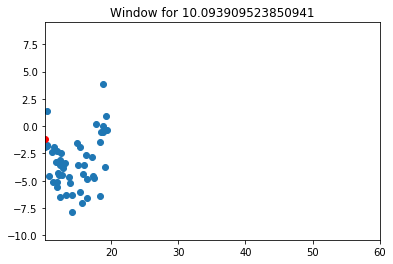

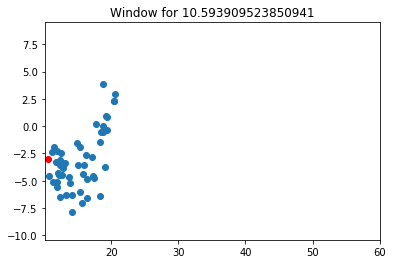

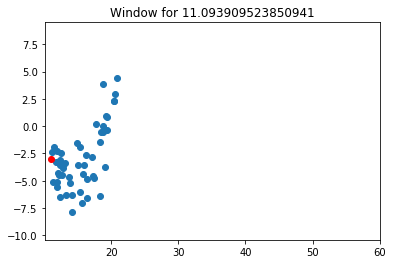

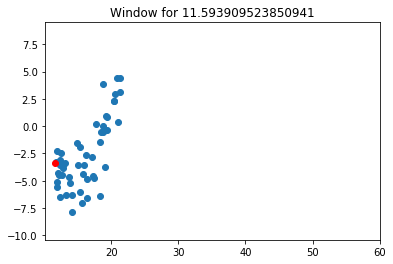

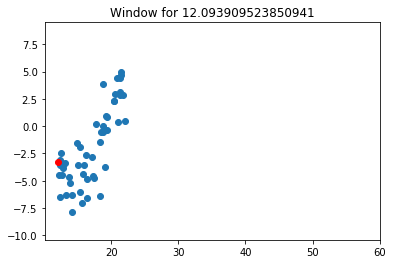

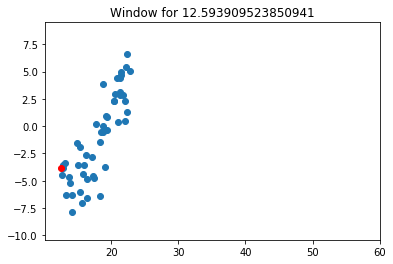

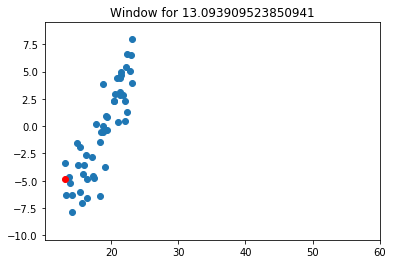

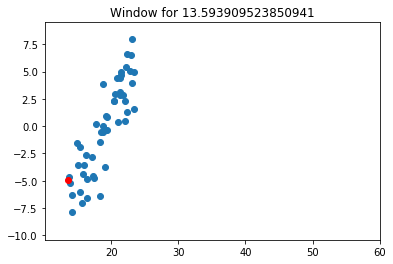

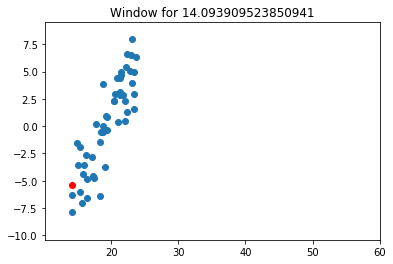

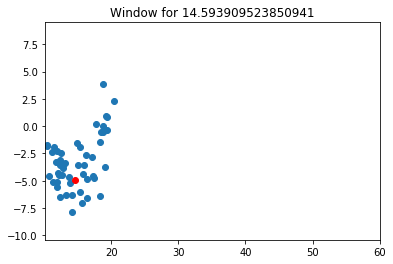

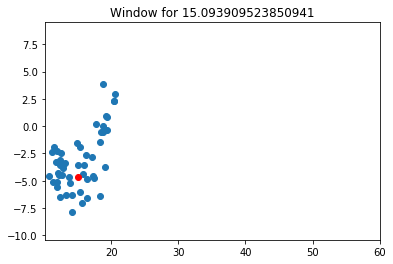

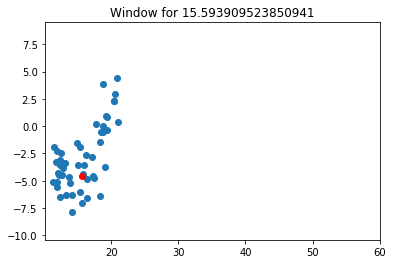

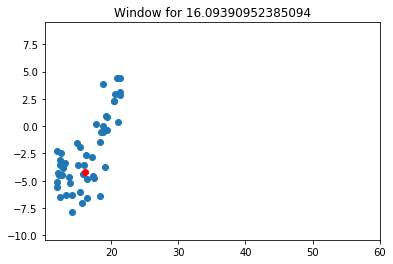

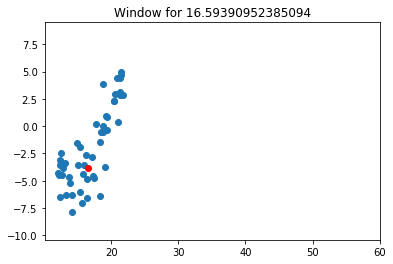

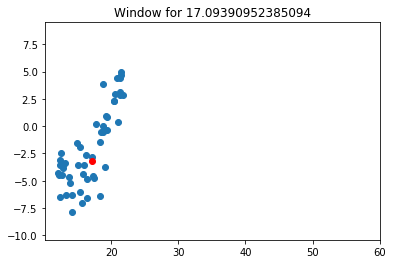

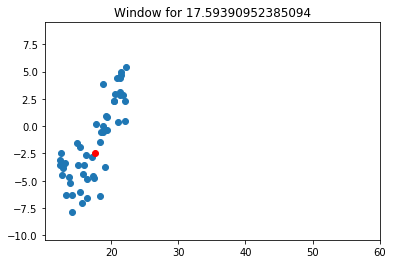

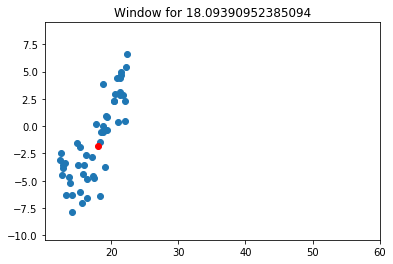

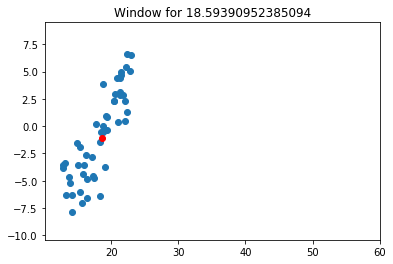

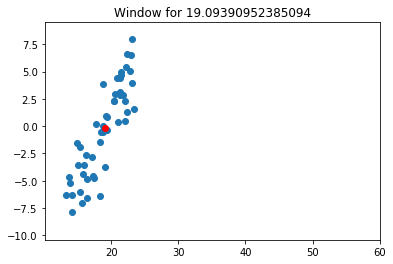

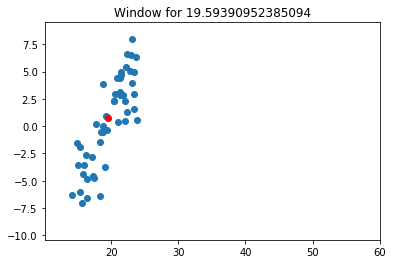

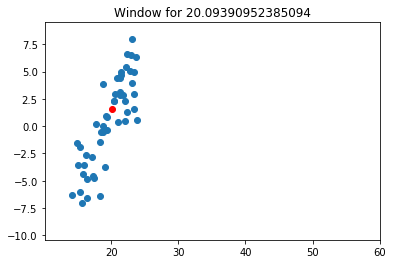

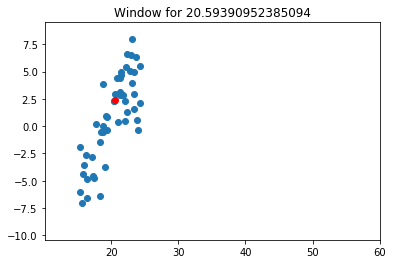

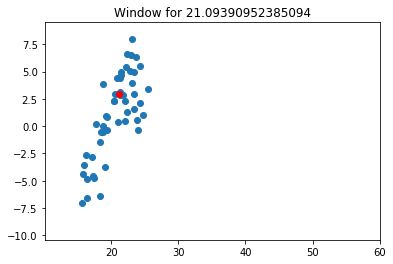

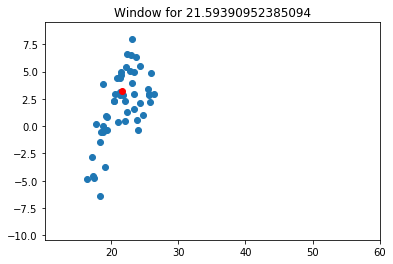

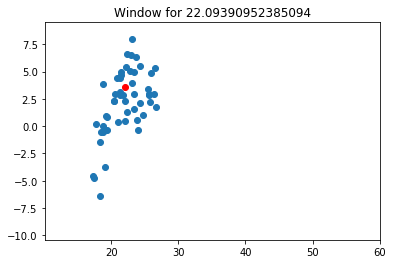

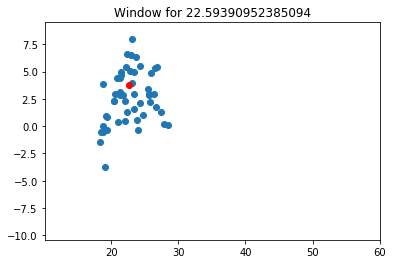

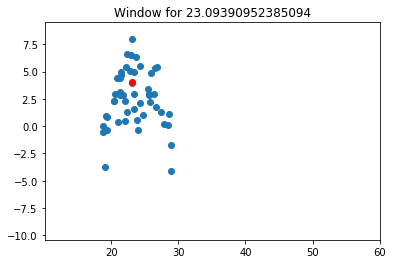

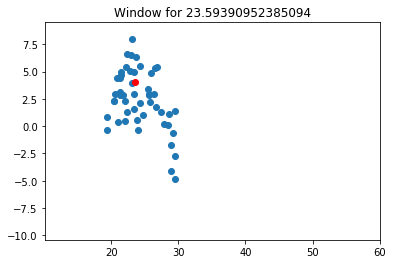

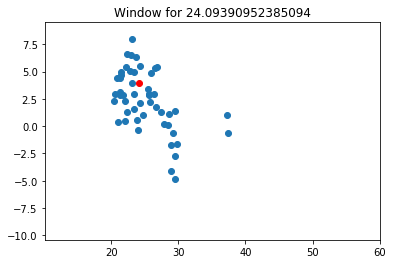

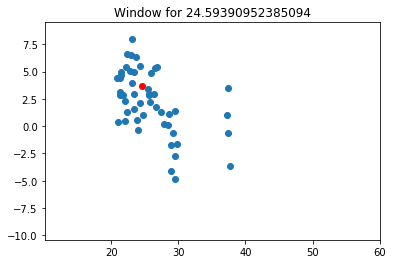

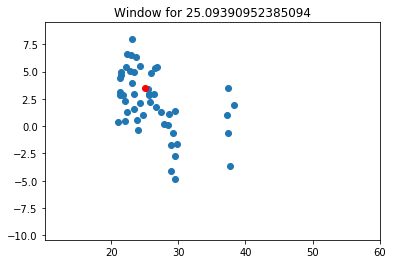

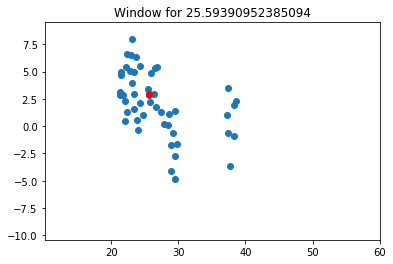

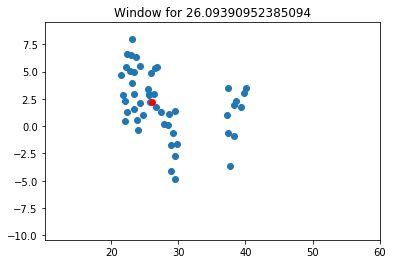

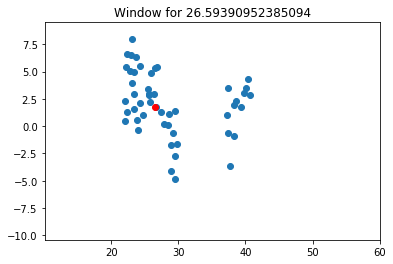

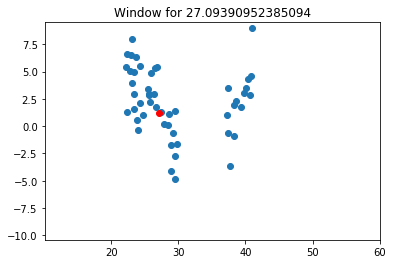

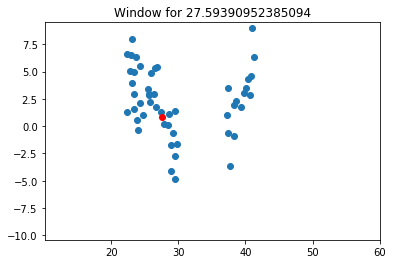

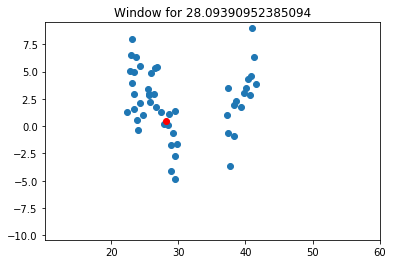

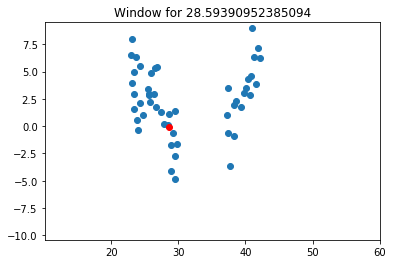

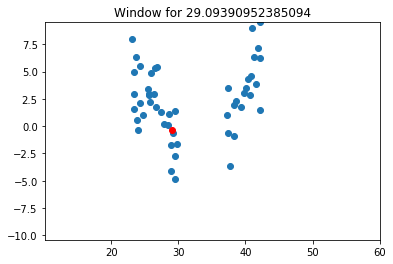

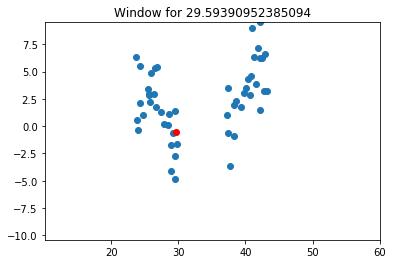

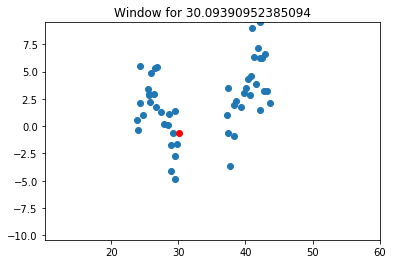

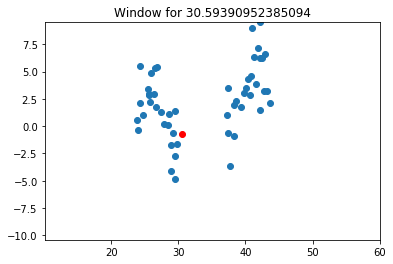

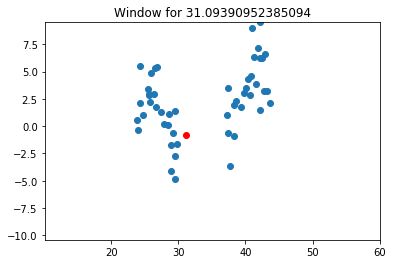

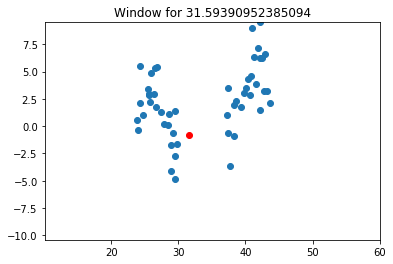

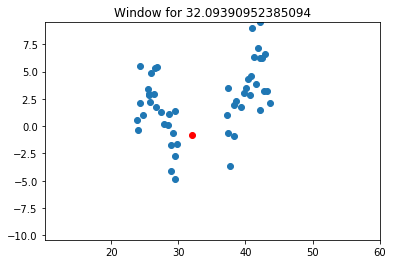

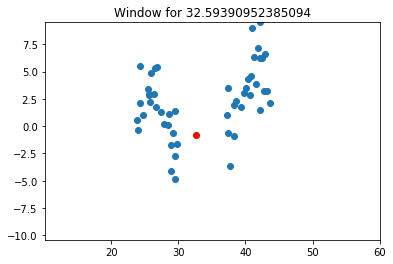

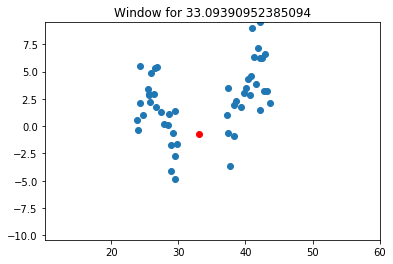

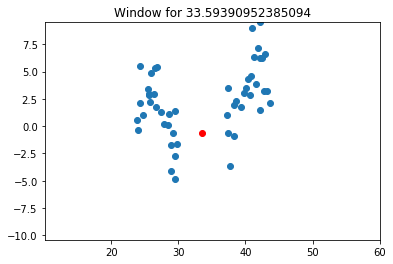

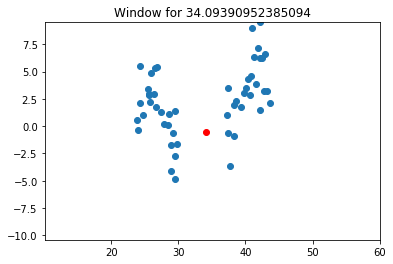

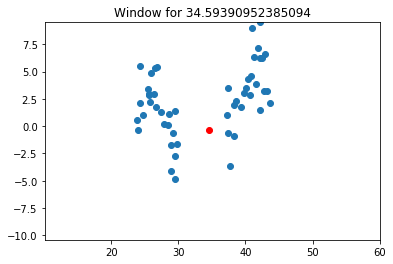

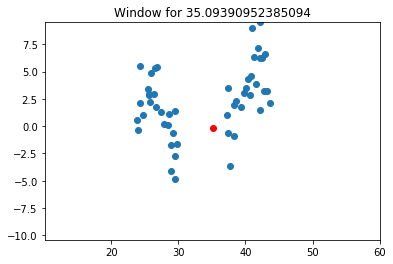

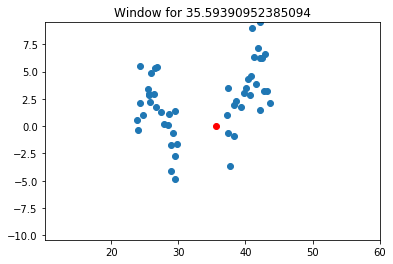

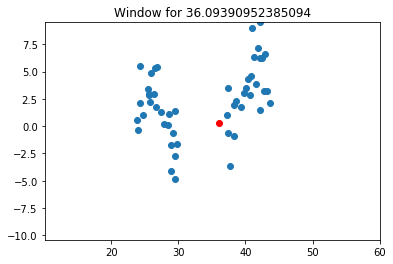

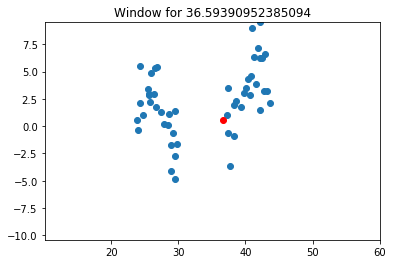

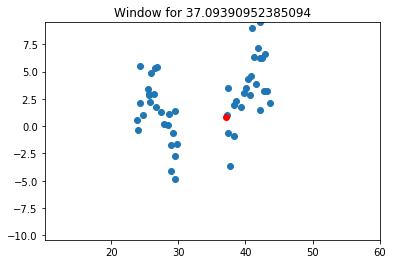

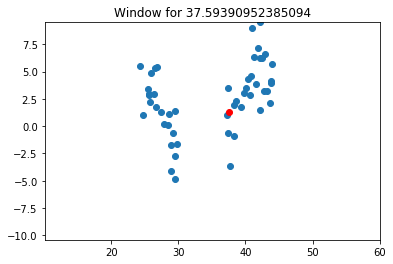

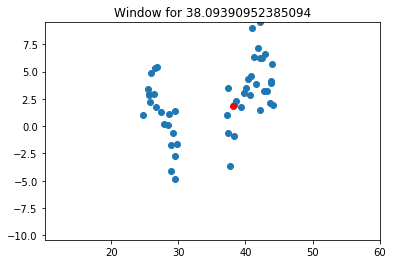

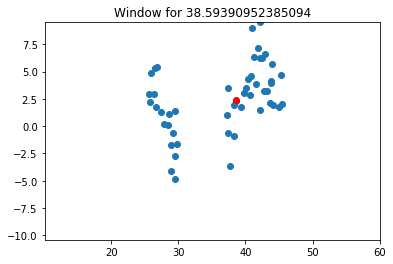

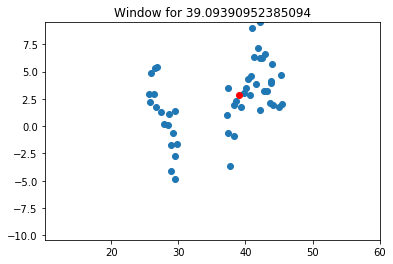

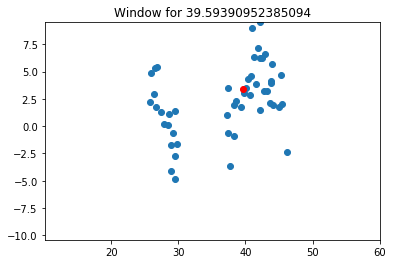

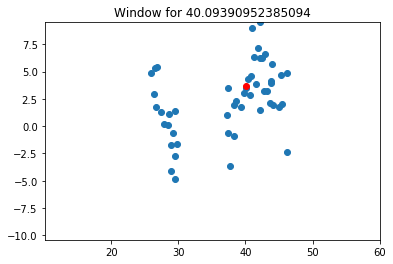

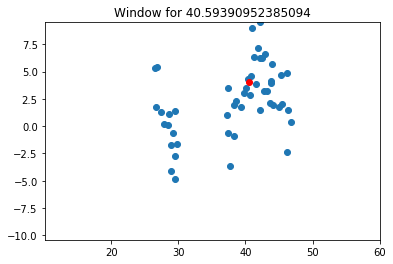

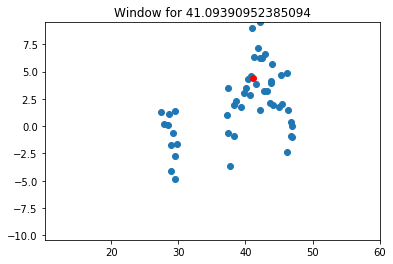

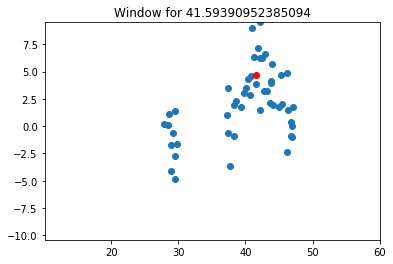

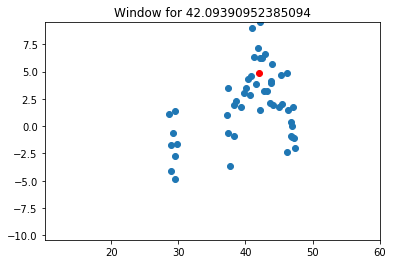

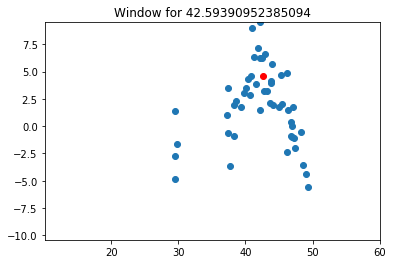

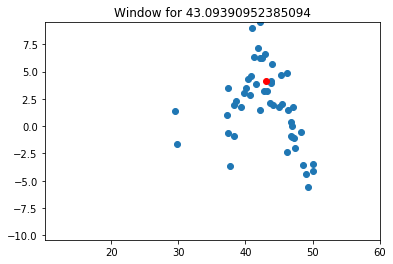

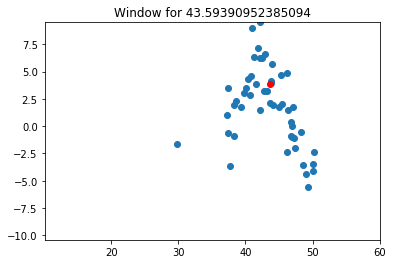

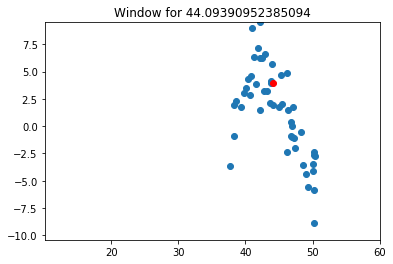

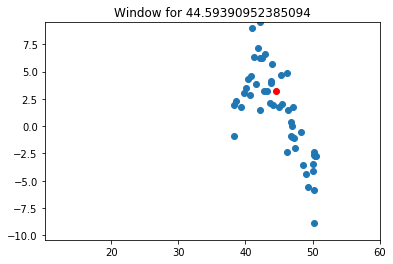

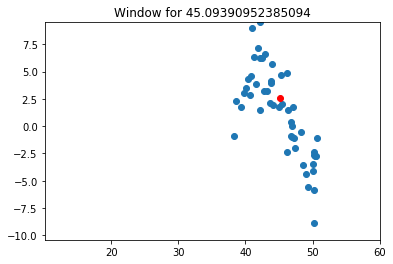

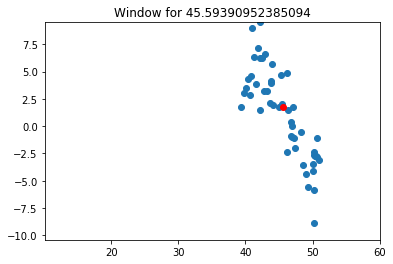

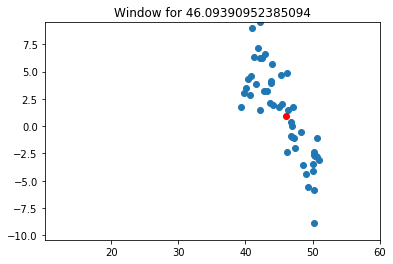

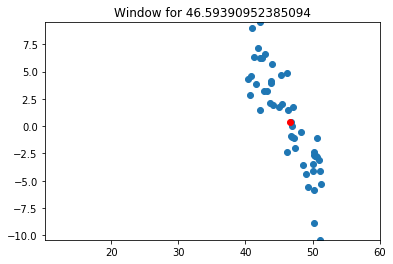

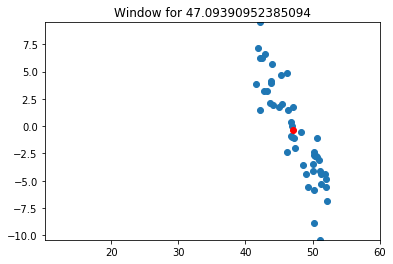

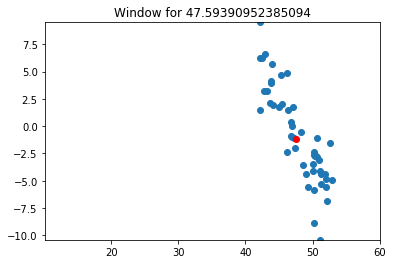

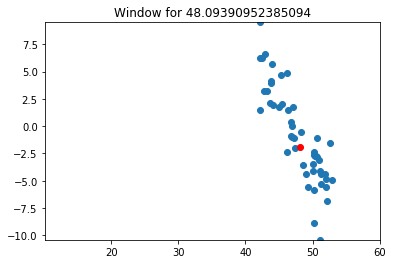

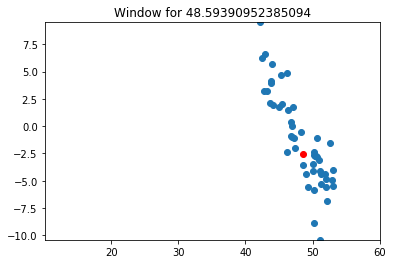

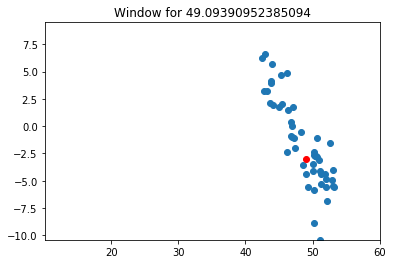

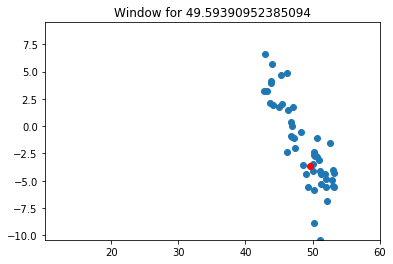

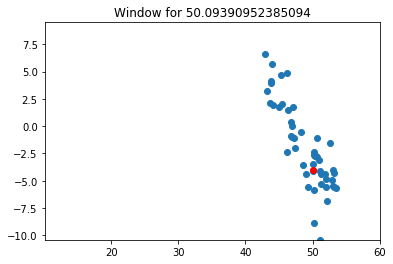

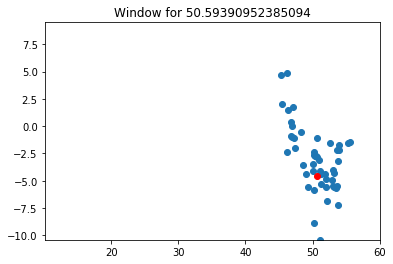

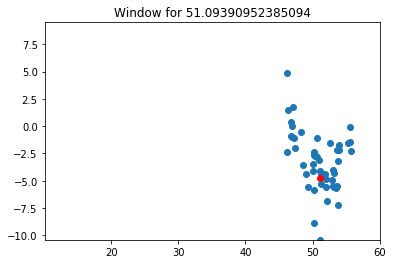

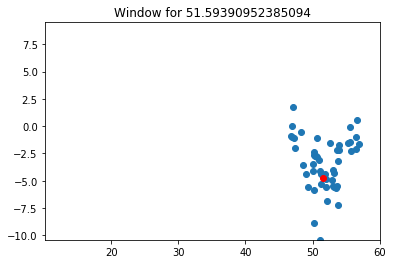

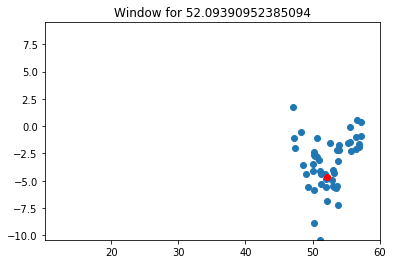

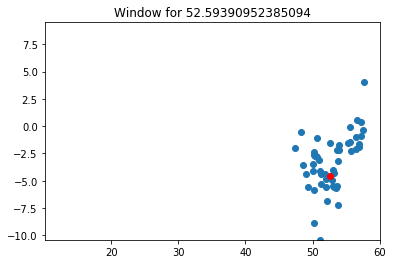

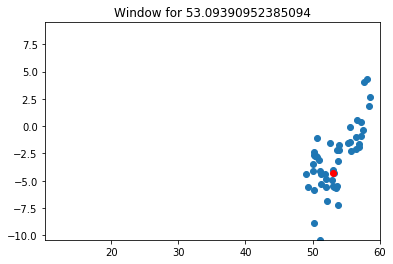

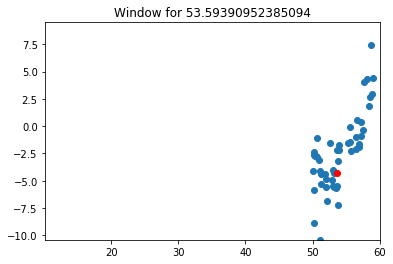

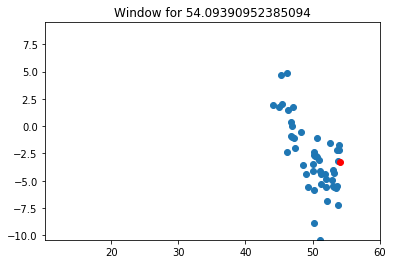

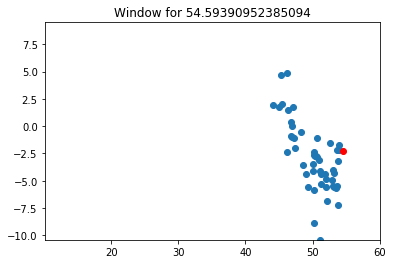

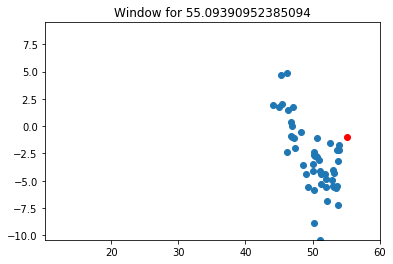

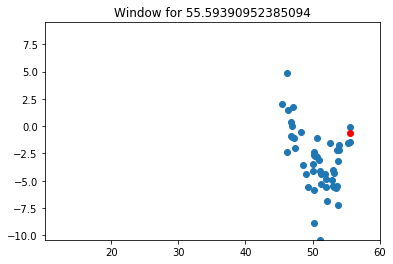

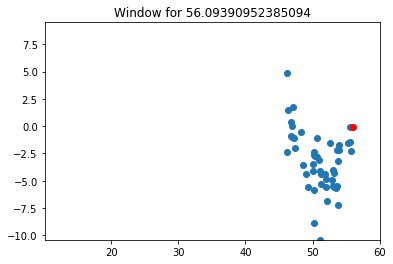

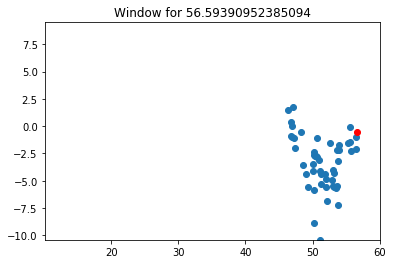

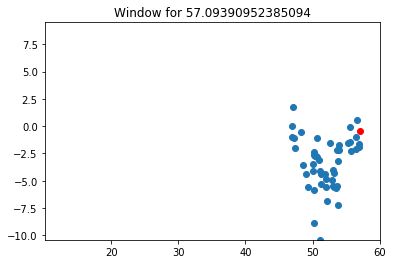

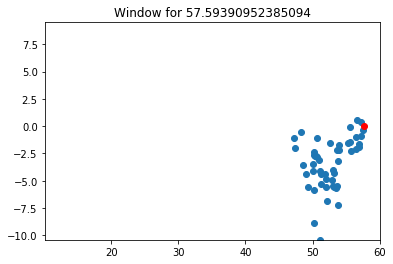

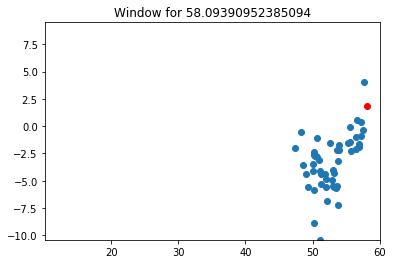

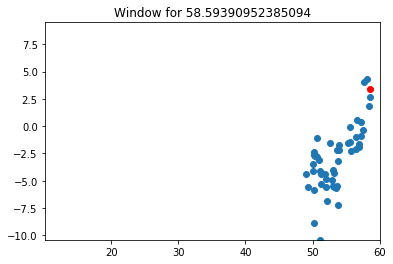

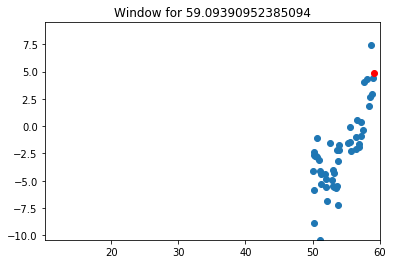

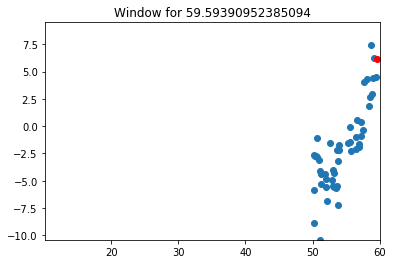

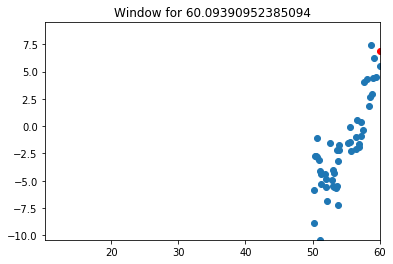

In [38]:
plot_loess_windows(x,y, smoother)

# Full plot

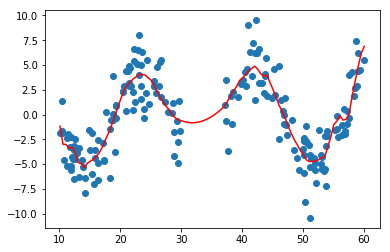

In [32]:
plt.scatter(x,y)
plt.plot(smoother.x_focal_base, smoother.y_focal_base, 'r')